In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from torch.optim.lr_scheduler import ReduceLROnPlateau
import time
import gc
import warnings
warnings.filterwarnings('ignore')

In [2]:
class VOCSegmentationTransform:
    def __init__(self, size, is_train=True):
        self.size = size
        self.is_train = is_train
        
        if is_train:
            self.image_transform = transforms.Compose([
                transforms.Resize(self.size, interpolation=Image.BILINEAR),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])
        else:
            self.image_transform = transforms.Compose([
                transforms.Resize(self.size, interpolation=Image.BILINEAR),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])
        
        self.mask_transform = transforms.Compose([
            transforms.Resize(self.size, interpolation=Image.NEAREST),
            transforms.PILToTensor(),
        ])

    def __call__(self, image, mask):
        # Simple random flip for training
        if self.is_train and torch.rand(1) < 0.5:
            image = transforms.functional.hflip(image)
            mask = transforms.functional.hflip(mask)
        
        image = self.image_transform(image)
        mask = self.mask_transform(mask).squeeze(0)
        return image, mask

In [3]:
class LightweightUNet(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.1):
        super(LightweightUNet, self).__init__()
        
        # Encoder - reduced channels
        self.encoder1 = self.contract_block(3, 32, dropout_rate)
        self.encoder2 = self.contract_block(32, 64, dropout_rate)
        self.encoder3 = self.contract_block(64, 128, dropout_rate)
        self.encoder4 = self.contract_block(128, 256, dropout_rate)
        
        # Bottleneck - reduced channels
        self.middle = self.contract_block(256, 512, dropout_rate)
        
        # Decoder
        self.up_transpose4 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.up_transpose3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.up_transpose2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.up_transpose1 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        
        self.upconv4 = self.expand_block(512, 256, dropout_rate)
        self.upconv3 = self.expand_block(256, 128, dropout_rate)
        self.upconv2 = self.expand_block(128, 64, dropout_rate)
        self.upconv1 = self.expand_block(64, 32, dropout_rate)
        
        self.final = nn.Conv2d(32, num_classes, kernel_size=1)
        
        # Initialize weights
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # Encoder
        e1 = self.encoder1(x)
        e2 = self.encoder2(F.max_pool2d(e1, 2))
        e3 = self.encoder3(F.max_pool2d(e2, 2))
        e4 = self.encoder4(F.max_pool2d(e3, 2))

        # Bottleneck
        m = self.middle(F.max_pool2d(e4, 2))

        # Decoder
        d4 = self.upconv4(torch.cat([self.up_transpose4(m), e4], dim=1))
        d3 = self.upconv3(torch.cat([self.up_transpose3(d4), e3], dim=1))
        d2 = self.upconv2(torch.cat([self.up_transpose2(d3), e2], dim=1))
        d1 = self.upconv1(torch.cat([self.up_transpose1(d2), e1], dim=1))

        return self.final(d1)

    def contract_block(self, in_channels, out_channels, dropout_rate):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout2d(dropout_rate),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def expand_block(self, in_channels, out_channels, dropout_rate):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout2d(dropout_rate),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

In [4]:
VOC_COLORS = [
    [0, 0, 0],        # 0: background
    [128, 0, 0],      # 1: aeroplane
    [0, 128, 0],      # 2: bicycle
    [128, 128, 0],    # 3: bird
    [0, 0, 128],      # 4: boat
    [128, 0, 128],    # 5: bottle
    [0, 128, 128],    # 6: bus
    [128, 128, 128],  # 7: car
    [64, 0, 0],       # 8: cat
    [192, 0, 0],      # 9: chair
    [64, 128, 0],     # 10: cow
    [192, 128, 0],    # 11: diningtable
    [64, 0, 128],     # 12: dog
    [192, 0, 128],    # 13: horse
    [64, 128, 128],   # 14: motorbike
    [192, 128, 128],  # 15: person
    [0, 64, 0],       # 16: pottedplant
    [128, 64, 0],     # 17: sheep
    [0, 192, 0],      # 18: sofa
    [128, 192, 0],    # 19: train
    [0, 64, 128]      # 20: tvmonitor
]


In [5]:
def denormalize_image(tensor):
    """Denormalize tensor for visualization"""
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    tensor = tensor * std + mean
    tensor = torch.clamp(tensor, 0, 1)
    return tensor.permute(1, 2, 0).cpu().numpy()

def mask_to_color(mask):
    """Convert class mask to RGB color mask"""
    h, w = mask.shape
    color_mask = np.zeros((h, w, 3), dtype=np.uint8)
    
    for class_id in range(21):
        class_pixels = (mask == class_id)
        color_mask[class_pixels] = VOC_COLORS[class_id]
    
    return color_mask

def overlay_mask_on_image(image, mask, alpha=0.6):
    """Overlay colored mask on original image"""
    color_mask = mask_to_color(mask)
    color_mask = color_mask.astype(np.float32) / 255.0
    overlay = image * (1 - alpha) + color_mask * alpha
    return np.clip(overlay, 0, 1)

In [6]:
def visualize_segmentation(model, val_loader, device, num_samples=4):
    """Memory-efficient visualization"""
    model.eval()
    samples = []
    
    with torch.no_grad():
        for i, (images, masks) in enumerate(val_loader):
            if len(samples) >= num_samples:
                break
            
            # Take only first image to save memory
            image = images[0].to(device)
            mask = masks[0].to(device)
            
            # Get prediction
            output = model(image.unsqueeze(0))
            pred = torch.argmax(output, dim=1).squeeze(0)
            
            # Move to CPU immediately
            samples.append({
                'image': denormalize_image(image.cpu()),
                'ground_truth': mask.cpu().numpy(),
                'prediction': pred.cpu().numpy()
            })
            
            # Clear GPU memory
            del image, mask, output, pred
            torch.cuda.empty_cache() if torch.cuda.is_available() else None
    
    # Create visualization
    fig, axes = plt.subplots(num_samples, 4, figsize=(16, 4*num_samples))
    if num_samples == 1:
        axes = axes.reshape(1, -1)
    
    for i, sample in enumerate(samples):
        image = sample['image']
        gt_mask = sample['ground_truth']
        pred_mask = sample['prediction']
        
        # Original image
        axes[i, 0].imshow(image)
        axes[i, 0].set_title('Original Image', fontsize=10)
        axes[i, 0].axis('off')
        
        # Ground truth mask
        gt_colored = mask_to_color(gt_mask)
        axes[i, 1].imshow(gt_colored)
        axes[i, 1].set_title('Ground Truth', fontsize=10)
        axes[i, 1].axis('off')
        
        # Predicted mask
        pred_colored = mask_to_color(pred_mask)
        axes[i, 2].imshow(pred_colored)
        axes[i, 2].set_title('Prediction', fontsize=10)
        axes[i, 2].axis('off')
        
        # Overlay
        overlay = overlay_mask_on_image(image, pred_mask, alpha=0.5)
        axes[i, 3].imshow(overlay)
        axes[i, 3].set_title('Overlay', fontsize=10)
        axes[i, 3].axis('off')
    
    plt.tight_layout()
    plt.show()


In [7]:
def plot_training_history(train_losses, val_losses, val_ious):
    """Plot training history"""
    if len(train_losses) == 0:
        return
        
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    epochs = range(1, len(train_losses) + 1)
    
    # Loss plot
    ax1.plot(epochs, train_losses, 'b-', label='Training Loss', linewidth=2)
    if len(val_losses) > 0:
        ax1.plot(epochs, val_losses, 'r-', label='Validation Loss', linewidth=2)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training Progress')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # IoU plot
    if len(val_ious) > 0:
        ax2.plot(epochs, val_ious, 'g-', label='Validation IoU', linewidth=2)
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Mean IoU')
        ax2.set_title('Validation IoU')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

In [ ]:
def evaluate_model_simple(model, val_loader, device):
    """Simple evaluation to avoid memory issues"""
    model.eval()
    total_correct = 0
    total_pixels = 0
    total_iou = 0
    num_batches = 0
    
    with torch.no_grad():
        for i, (images, masks) in enumerate(val_loader):
            if i >= 10: 
                break
                
            images = images.to(device)
            masks = masks.to(device)
            
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            
            # Calculate metrics
            valid_mask = masks != 255
            correct = (preds[valid_mask] == masks[valid_mask]).sum().item()
            pixels = valid_mask.sum().item()
            
            total_correct += correct
            total_pixels += pixels
            num_batches += 1
            
            # Simple IoU calculation
            intersection = (preds == masks).sum().item()
            union = preds.numel()
            total_iou += intersection / union if union > 0 else 0
            
            # Clear memory
            del images, masks, outputs, preds
            torch.cuda.empty_cache() if torch.cuda.is_available() else None
    
    pixel_acc = total_correct / total_pixels if total_pixels > 0 else 0
    mean_iou = total_iou / num_batches if num_batches > 0 else 0
    
    return pixel_acc, mean_iou

In [9]:
def train_model():
    # Check available memory
    if torch.cuda.is_available():
        print(f"GPU: {torch.cuda.get_device_name()}")
        print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
    
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Create transforms with smaller size
    train_transform = VOCSegmentationTransform(size=(128, 128), is_train=True)
    val_transform = VOCSegmentationTransform(size=(128, 128), is_train=False)
    
    # Create datasets
    try:
        train_dataset = torchvision.datasets.VOCSegmentation(
            root='./data', year='2012', image_set='train',
            download=False, transforms=train_transform
        )
        
        val_dataset = torchvision.datasets.VOCSegmentation(
            root='./data', year='2012', image_set='val',
            download=False, transforms=val_transform
        )
        
        print(f"Dataset loaded: {len(train_dataset)} train, {len(val_dataset)} val")
        
    except Exception as e:
        print(f"Error loading dataset: {e}")
        return
    
    # Create data loaders with smaller batch size
    train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, num_workers=0)
    
    # Create lightweight model
    model = LightweightUNet(num_classes=21, dropout_rate=0.1).to(device)
    
    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    
    # Simple loss and optimizer
    criterion = nn.CrossEntropyLoss(ignore_index=255)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
    
    # Training parameters
    num_epochs = 100 
    train_losses = []
    val_losses = []
    val_ious = []
        
    try:
        for epoch in range(num_epochs):
            start_time = time.time()
            
            # Training phase
            model.train()
            running_loss = 0.0
            batch_count = 0
            
            for batch_idx, (images, masks) in enumerate(train_loader):
                try:
                    images = images.to(device)
                    masks = masks.long().to(device)
                    
                    optimizer.zero_grad()
                    outputs = model(images)
                    loss = criterion(outputs, masks)
                    loss.backward()
                    optimizer.step()
                    
                    running_loss += loss.item()
                    batch_count += 1
                    
                    # Clear memory
                    del images, masks, outputs, loss
                    torch.cuda.empty_cache() if torch.cuda.is_available() else None
                    
                    if batch_idx >= 50:  # Limit training batches
                        break
                        
                except Exception as e:
                    print(f"Error in training batch {batch_idx}: {e}")
                    continue
            
            train_loss = running_loss / batch_count if batch_count > 0 else 0
            train_losses.append(train_loss)
            
            # Validation phase
            model.eval()
            val_loss = 0.0
            val_batch_count = 0
            
            with torch.no_grad():
                for batch_idx, (images, masks) in enumerate(val_loader):
                    try:
                        images = images.to(device)
                        masks = masks.long().to(device)
                        
                        outputs = model(images)
                        loss = criterion(outputs, masks)
                        val_loss += loss.item()
                        val_batch_count += 1
                        
                        # Clear memory
                        del images, masks, outputs, loss
                        torch.cuda.empty_cache() if torch.cuda.is_available() else None
                        
                        if batch_idx >= 10:  # Limit validation batches
                            break
                            
                    except Exception as e:
                        print(f"Error in validation batch {batch_idx}: {e}")
                        continue
            
            val_loss = val_loss / val_batch_count if val_batch_count > 0 else 0
            val_losses.append(val_loss)
            
            # Simple evaluation
            try:
                pixel_acc, mean_iou = evaluate_model_simple(model, val_loader, device)
                val_ious.append(mean_iou)
            except Exception as e:
                print(f"Error in evaluation: {e}")
                pixel_acc, mean_iou = 0, 0
                val_ious.append(0)
            
            # Update scheduler
            scheduler.step(val_loss)
            
            # Print progress
            epoch_time = time.time() - start_time
            print(f'Epoch [{epoch+1}/{num_epochs}] - {epoch_time:.1f}s')
            print(f'Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
            print(f'Pixel Acc: {pixel_acc:.4f}, Mean IoU: {mean_iou:.4f}')
            print('-' * 50)
            
            # Force garbage collection
            gc.collect()
            torch.cuda.empty_cache() if torch.cuda.is_available() else None
    
    except Exception as e:
        print(f"Training error: {e}")
        return None, None, None, None
        
    # Plot results
    try:
        plot_training_history(train_losses, val_losses, val_ious)
    except Exception as e:
        print(f"Error: {e}")
    
    # Visualize results
    try:
        visualize_segmentation(model, val_loader, device, num_samples=4)
    except Exception as e:
        print(f"Error: {e}")
    
    return model, train_losses, val_losses, val_ious

GPU: NVIDIA GeForce RTX 2070 SUPER
Memory: 7.6 GB
Using device: cuda
Dataset loaded: 1464 train, 1449 val
Total parameters: 7,766,645
Trainable parameters: 7,766,645
Epoch [1/100] - 3.6s
Train Loss: 3.0800, Val Loss: 2.8349
Pixel Acc: 0.3475, Mean IoU: 0.3298
--------------------------------------------------
Epoch [2/100] - 3.1s
Train Loss: 2.0846, Val Loss: 2.8517
Pixel Acc: 0.6209, Mean IoU: 0.5891
--------------------------------------------------
Epoch [3/100] - 3.2s
Train Loss: 1.7792, Val Loss: 1.9739
Pixel Acc: 0.6641, Mean IoU: 0.6302
--------------------------------------------------
Epoch [4/100] - 2.8s
Train Loss: 1.4589, Val Loss: 1.8431
Pixel Acc: 0.6815, Mean IoU: 0.6467
--------------------------------------------------
Epoch [5/100] - 2.8s
Train Loss: 1.4385, Val Loss: 1.5286
Pixel Acc: 0.6801, Mean IoU: 0.6453
--------------------------------------------------
Epoch [6/100] - 2.7s
Train Loss: 1.3728, Val Loss: 1.4692
Pixel Acc: 0.6797, Mean IoU: 0.6450
---------------

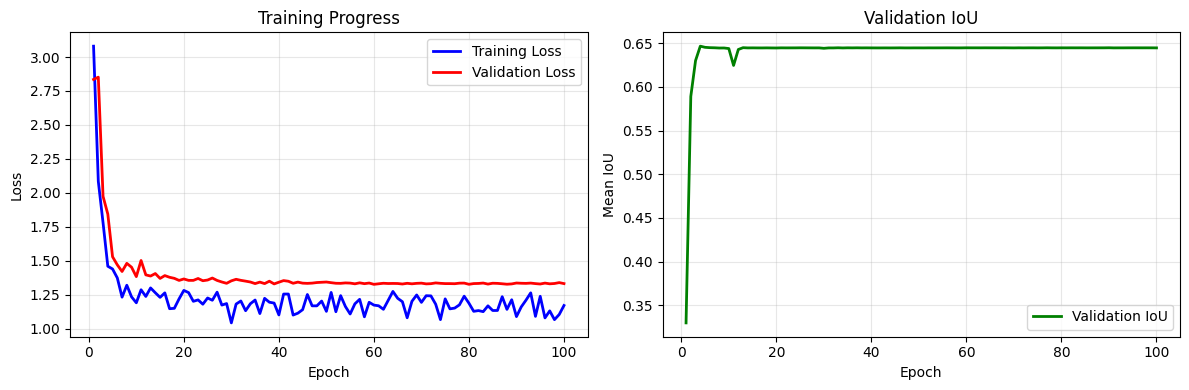

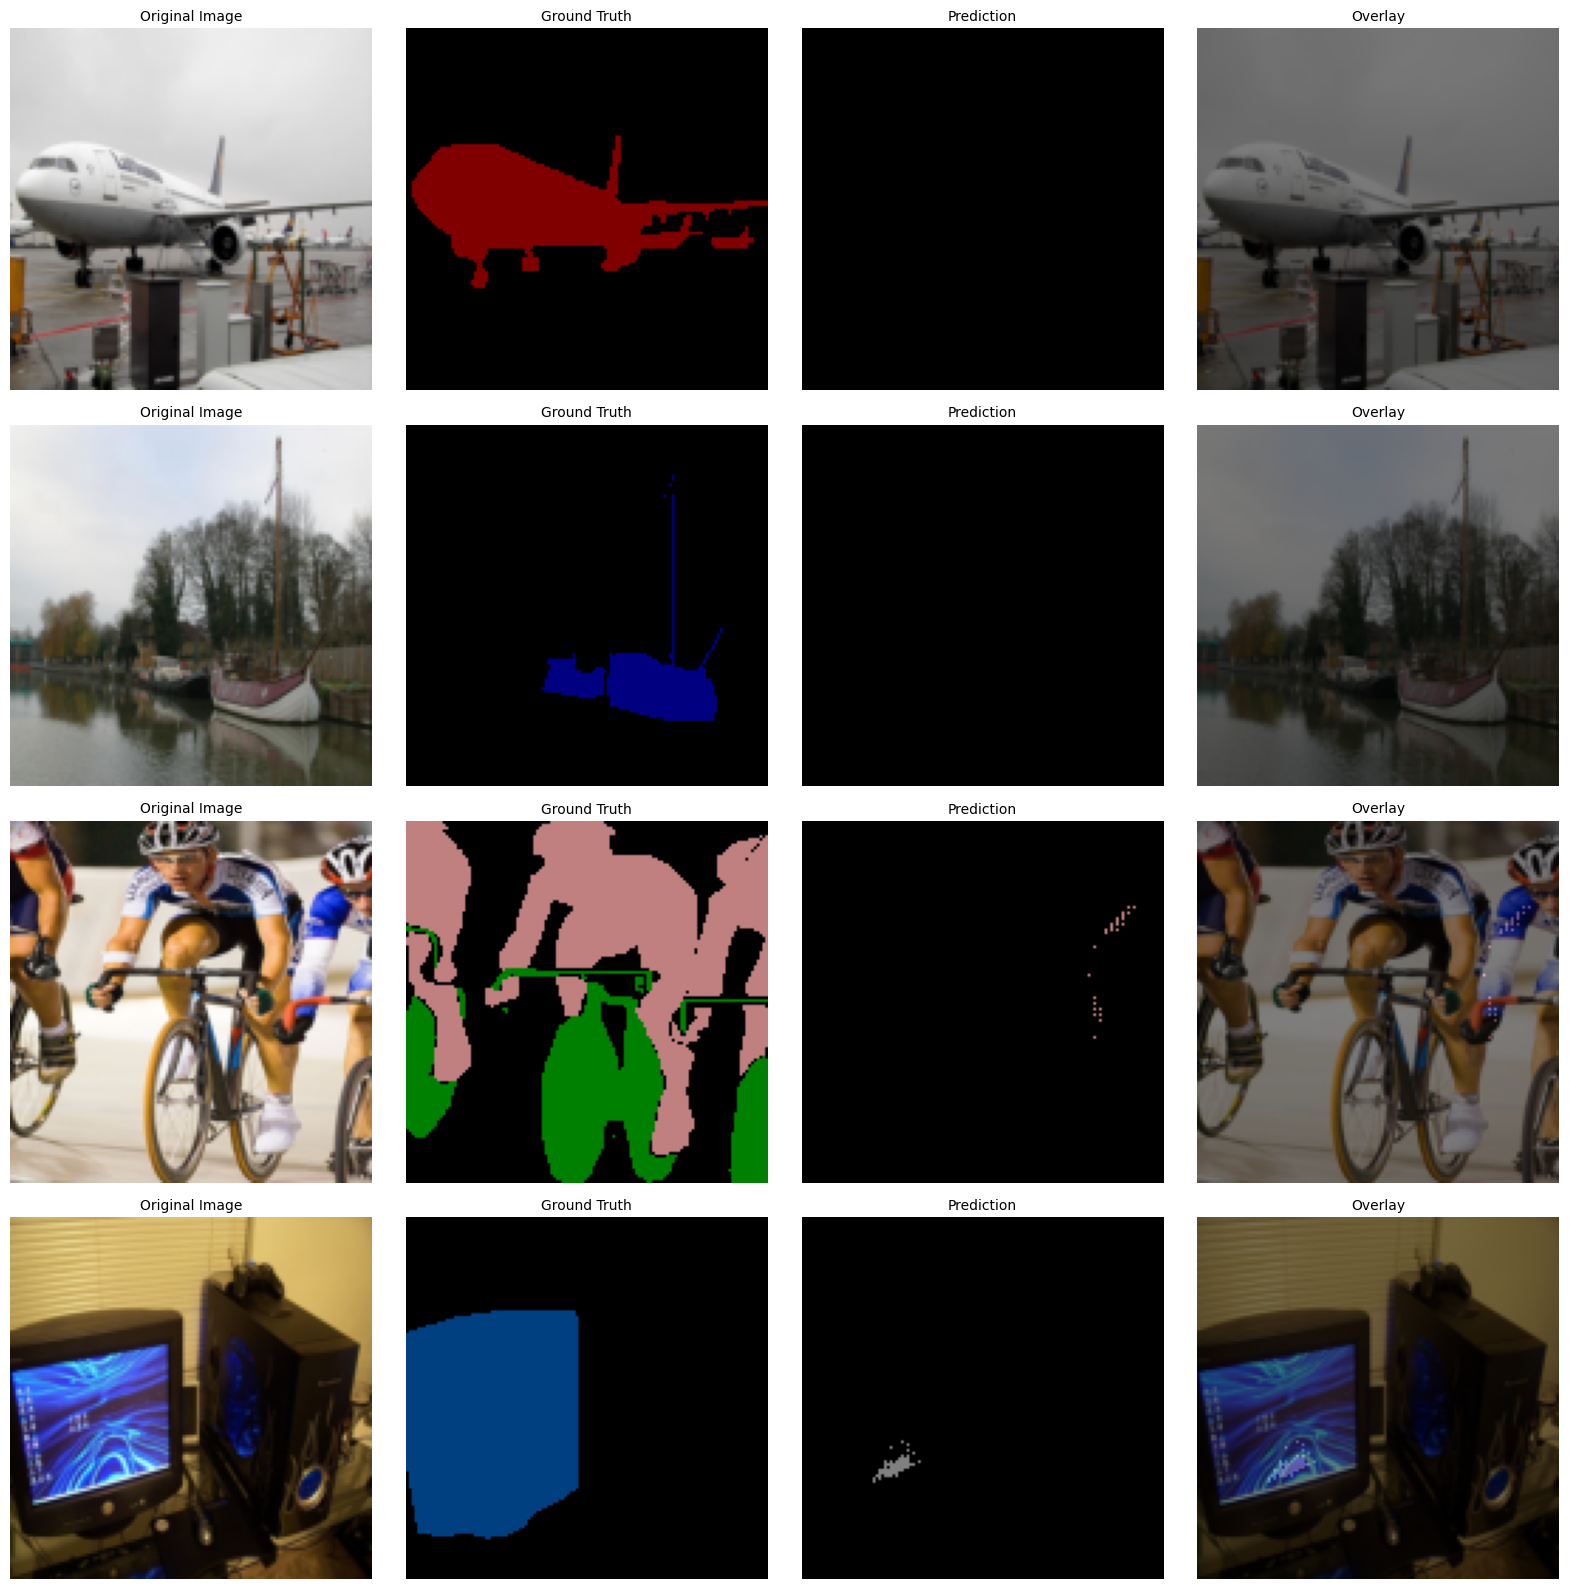

In [10]:

if __name__ == "__main__":
    model, train_losses, val_losses, val_ious = train_model()